In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

model_ckpt = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = 'Affectnet/Manually_Annotated/Manually_Annotated_Images'

In [40]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os


def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [ ]:
class AffectNetDataset(Dataset):
    def __init__(self,
                 csvfile,
                 root,
                 mode='classification',
                 crop=False,
                 transform=None,
                 invalid_files=None):
        assert mode in ('valence', 'arousal', 'valence-arousal', 'classification')
        self.df = pd.read_csv(csvfile)
        self.root = root
        self.mode = mode
        self.crop = crop
        self.transform = transform
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
            self.df = self.df
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'classification':
            target = torch.tensor(self.df['expression'][idx])
        elif self.mode == 'valence':
            target = torch.tensor([self.df['valence'][idx]])
        elif self.mode == 'arousal':
            target = torch.tensor([self.df['arousal'][idx]])
        else:
            target = torch.tensor([self.df['valence'][idx],
                                   self.df['arousal'][idx]])
        return img.float(), target.float()
    
    def __len__(self):
        return len(self.df)

In [5]:
class AffectNetDatasetForSupCon(Dataset):
    def __init__(self,
                 csvfile,
                 root,
                 transform,
                 crop=False,
                 invalid_files=None):
        self.df = pd.read_csv(csvfile)
        self.root = root
        self.crop = crop
        self.transform = transform
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
            self.df = self.df
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        img1 = self.transform(img)
        img2 = self.transform(img)
        target = torch.tensor(self.df['expression'][idx])
        return (img1.float(), img2.float()), target
    
    def __len__(self):
        return len(self.df)

In [7]:
def contrastive_collate_fn(examples):
    imgs, targets = zip(*examples)
    imgs1, imgs2 = zip(*imgs)
    imgs1 = torch.stack(imgs1)
    imgs2 = torch.stack(imgs2)
    pixel_values = torch.cat([imgs1, imgs2])
    targets = torch.stack(targets)
    return {'pixel_values': pixel_values, 'labels': targets}

In [1]:
train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']
val_invalid_files = []

In [10]:
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomApply,
                                    ColorJitter,
                                    RandomGrayscale,
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

supcon_transform = Compose([
    RandomResizedCrop(size=tuple(feature_extractor.size.values()), scale=(0.2, 1.)),
    RandomHorizontalFlip(),
    RandomApply([
        ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    RandomGrayscale(p=0.2),
    ToTensor(),
    normalize
])

contrastive_dataset = AffectNetDatasetForSupCon('Affectnet/training.csv',
                                                images_root,
                                                crop=False,
                                                transform=supcon_transform,
                                                invalid_files=train_invalid_files)

print('contrastive:', len(contrastive_dataset))

contrastive: 320739
train: 320739
validation: 4500


In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(contrastive_dataset, collate_fn=contrastive_collate_fn, batch_size=4)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([8, 3, 224, 224])
labels torch.Size([4])


contrastive learning(https://arxiv.org/abs/2004.11362)による準事前学習

In [12]:
from transformers import Trainer

from SupContrast.losses import SupConLoss

class SupConTrainer(Trainer):
    def __init__(self,
                 model = None,
                 args = None,
                 data_collator = None,
                 train_dataset = None,
                 eval_dataset = None,
                 tokenizer = None,
                 model_init = None,
                 compute_metrics = None,
                 callbacks = None,
                 optimizers = (None, None),
                 preprocess_logits_for_metrics = None):
        super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init, compute_metrics, callbacks, optimizers, preprocess_logits_for_metrics)
        self.loss_fct = SupConLoss()
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        bsz = labels.shape[0]
        outputs = model(pixel_values=inputs.get('pixel_values'), output_hidden_states=True)
        features = outputs.get('logits')
        f1, f2 = torch.split(features, [bsz, bsz])
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        loss = self.loss_fct(features, labels)
        return (loss, features) if return_outputs else loss

In [13]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=128,
                                                  problem_type='regression')


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformers import TrainingArguments
import wandb

wandb.init(project='AffectNet-vit', name='contrastive-pretrain-valaro')

contrastive_args = TrainingArguments(
    f"affectnet-contrastive",
    save_strategy='steps',
    save_steps=500,
    learning_rate=1e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=200,
    weight_decay=1e-3,
    logging_dir='contrastive-logs',
    logging_strategy='steps',
    logging_steps=100,
    remove_unused_columns=False,
    report_to='wandb'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rkn. Use `wandb login --relogin` to force relogin


In [15]:
from transformers import EarlyStoppingCallback

contrastive_trainer = SupConTrainer(
    model,
    contrastive_args,
    train_dataset=contrastive_dataset,
    data_collator=contrastive_collate_fn,
    tokenizer=feature_extractor,
)

In [16]:
contrastive_trainer.train()

  1%|          | 49400/4009400 [12:19:28<2509:16:28,  2.28s/it]

{'loss': 2.8972, 'learning_rate': 9.87678954457026e-07, 'epoch': 2.46}


  1%|          | 49500/4009400 [12:21:11<821:39:13,  1.34it/s] 

{'loss': 2.8626, 'learning_rate': 9.876540130692871e-07, 'epoch': 2.47}


  1%|          | 49600/4009400 [12:22:56<808:36:43,  1.36it/s] 

{'loss': 2.8346, 'learning_rate': 9.876290716815483e-07, 'epoch': 2.47}


  1%|          | 49700/4009400 [12:24:13<828:12:46,  1.33it/s]

{'loss': 2.8437, 'learning_rate': 9.876041302938095e-07, 'epoch': 2.48}


  1%|          | 49800/4009400 [12:25:30<862:41:49,  1.27it/s]

{'loss': 2.8463, 'learning_rate': 9.875791889060707e-07, 'epoch': 2.48}


  1%|          | 49900/4009400 [12:26:48<935:08:43,  1.18it/s] 

{'loss': 2.8585, 'learning_rate': 9.875542475183319e-07, 'epoch': 2.49}


  1%|          | 50000/4009400 [12:28:05<845:53:24,  1.30it/s] 

{'loss': 2.8639, 'learning_rate': 9.87529306130593e-07, 'epoch': 2.49}


  1%|          | 50100/4009400 [12:29:34<854:52:35,  1.29it/s] 

{'loss': 2.831, 'learning_rate': 9.875043647428543e-07, 'epoch': 2.5}


  1%|▏         | 50200/4009400 [12:30:54<878:16:52,  1.25it/s] 

{'loss': 2.8381, 'learning_rate': 9.874794233551155e-07, 'epoch': 2.5}


  1%|▏         | 50300/4009400 [12:32:11<828:27:00,  1.33it/s]

{'loss': 2.8557, 'learning_rate': 9.874544819673767e-07, 'epoch': 2.51}


  1%|▏         | 50400/4009400 [12:33:27<837:58:15,  1.31it/s]

{'loss': 2.8363, 'learning_rate': 9.874295405796378e-07, 'epoch': 2.51}


  1%|▏         | 50500/4009400 [12:34:45<817:43:32,  1.34it/s]

{'loss': 2.8253, 'learning_rate': 9.87404599191899e-07, 'epoch': 2.52}


  1%|▏         | 50600/4009400 [12:36:12<845:29:56,  1.30it/s] 

{'loss': 2.8349, 'learning_rate': 9.873796578041602e-07, 'epoch': 2.52}


  1%|▏         | 50700/4009400 [12:37:29<823:02:27,  1.34it/s]

{'loss': 2.8138, 'learning_rate': 9.873547164164212e-07, 'epoch': 2.53}


  1%|▏         | 50800/4009400 [12:38:45<827:46:08,  1.33it/s]

{'loss': 2.8572, 'learning_rate': 9.873297750286826e-07, 'epoch': 2.53}


  1%|▏         | 50900/4009400 [12:40:02<833:37:52,  1.32it/s]

{'loss': 2.8252, 'learning_rate': 9.873048336409438e-07, 'epoch': 2.54}


  1%|▏         | 51000/4009400 [12:41:20<842:30:10,  1.31it/s]

{'loss': 2.8499, 'learning_rate': 9.87279892253205e-07, 'epoch': 2.54}


  1%|▏         | 51100/4009400 [12:43:01<861:45:15,  1.28it/s] 

{'loss': 2.8066, 'learning_rate': 9.87254950865466e-07, 'epoch': 2.55}


  1%|▏         | 51200/4009400 [12:44:18<874:58:43,  1.26it/s]

{'loss': 2.8973, 'learning_rate': 9.872300094777272e-07, 'epoch': 2.55}


  1%|▏         | 51300/4009400 [12:45:35<914:12:39,  1.20it/s]

{'loss': 2.861, 'learning_rate': 9.872050680899886e-07, 'epoch': 2.56}


  1%|▏         | 51400/4009400 [12:47:22<922:31:26,  1.19it/s] 

{'loss': 2.8806, 'learning_rate': 9.871801267022498e-07, 'epoch': 2.56}


  1%|▏         | 51500/4009400 [12:48:54<1029:15:10,  1.07it/s]

{'loss': 2.8293, 'learning_rate': 9.871551853145108e-07, 'epoch': 2.57}


  1%|▏         | 51600/4009400 [12:50:52<966:36:04,  1.14it/s] 

{'loss': 2.8562, 'learning_rate': 9.87130243926772e-07, 'epoch': 2.57}


  1%|▏         | 51700/4009400 [12:52:21<846:58:28,  1.30it/s] 

{'loss': 2.8622, 'learning_rate': 9.871053025390331e-07, 'epoch': 2.58}


  1%|▏         | 51800/4009400 [12:53:38<851:53:53,  1.29it/s] 

{'loss': 2.8535, 'learning_rate': 9.870803611512945e-07, 'epoch': 2.58}


  1%|▏         | 51900/4009400 [12:54:56<1354:24:48,  1.23s/it]

{'loss': 2.84, 'learning_rate': 9.870554197635555e-07, 'epoch': 2.59}


  1%|▏         | 52000/4009400 [12:56:14<799:18:45,  1.38it/s] 

{'loss': 2.8374, 'learning_rate': 9.870304783758167e-07, 'epoch': 2.59}


  1%|▏         | 52100/4009400 [12:58:54<910:44:39,  1.21it/s] 

{'loss': 2.8296, 'learning_rate': 9.87005536988078e-07, 'epoch': 2.6}


  1%|▏         | 52200/4009400 [13:00:14<839:04:27,  1.31it/s] 

{'loss': 2.8579, 'learning_rate': 9.86980595600339e-07, 'epoch': 2.6}


  1%|▏         | 52300/4009400 [13:01:40<856:36:50,  1.28it/s] 

{'loss': 2.8194, 'learning_rate': 9.869556542126003e-07, 'epoch': 2.61}


  1%|▏         | 52400/4009400 [13:03:09<892:26:23,  1.23it/s] 

{'loss': 2.8585, 'learning_rate': 9.869307128248615e-07, 'epoch': 2.61}


  1%|▏         | 52500/4009400 [13:04:37<911:23:11,  1.21it/s] 

{'loss': 2.8794, 'learning_rate': 9.869057714371227e-07, 'epoch': 2.62}


  1%|▏         | 52600/4009400 [13:06:15<861:23:49,  1.28it/s] 

{'loss': 2.8139, 'learning_rate': 9.868808300493839e-07, 'epoch': 2.62}


  1%|▏         | 52700/4009400 [13:07:33<799:13:47,  1.38it/s]

{'loss': 2.8383, 'learning_rate': 9.86855888661645e-07, 'epoch': 2.63}


  1%|▏         | 52800/4009400 [13:08:52<886:40:08,  1.24it/s]

{'loss': 2.8441, 'learning_rate': 9.868309472739063e-07, 'epoch': 2.63}


  1%|▏         | 52900/4009400 [13:10:09<832:35:11,  1.32it/s]

{'loss': 2.7843, 'learning_rate': 9.868060058861675e-07, 'epoch': 2.64}


  1%|▏         | 53000/4009400 [13:11:37<1088:27:48,  1.01it/s]

{'loss': 2.8115, 'learning_rate': 9.867810644984286e-07, 'epoch': 2.64}


  1%|▏         | 53100/4009400 [13:13:13<835:59:26,  1.31it/s] 

{'loss': 2.841, 'learning_rate': 9.867561231106898e-07, 'epoch': 2.65}


  1%|▏         | 53200/4009400 [13:14:31<852:22:42,  1.29it/s]

{'loss': 2.8589, 'learning_rate': 9.86731181722951e-07, 'epoch': 2.65}


  1%|▏         | 53300/4009400 [13:16:02<946:50:27,  1.16it/s] 

{'loss': 2.8619, 'learning_rate': 9.867062403352122e-07, 'epoch': 2.66}


  1%|▏         | 53400/4009400 [13:17:20<816:23:17,  1.35it/s]

{'loss': 2.856, 'learning_rate': 9.866812989474734e-07, 'epoch': 2.66}


  1%|▏         | 53500/4009400 [13:18:37<845:21:01,  1.30it/s]

{'loss': 2.8612, 'learning_rate': 9.866563575597346e-07, 'epoch': 2.67}


  1%|▏         | 53600/4009400 [13:20:09<859:23:22,  1.28it/s] 

{'loss': 2.8686, 'learning_rate': 9.866314161719958e-07, 'epoch': 2.67}


  1%|▏         | 53700/4009400 [13:21:33<846:15:58,  1.30it/s] 

{'loss': 2.8472, 'learning_rate': 9.86606474784257e-07, 'epoch': 2.68}


  1%|▏         | 53800/4009400 [13:23:00<868:30:48,  1.27it/s] 

{'loss': 2.8428, 'learning_rate': 9.865815333965182e-07, 'epoch': 2.68}


  1%|▏         | 53900/4009400 [13:24:22<877:01:17,  1.25it/s] 

{'loss': 2.7929, 'learning_rate': 9.865565920087794e-07, 'epoch': 2.69}


  1%|▏         | 54000/4009400 [13:25:42<860:28:28,  1.28it/s] 

{'loss': 2.8769, 'learning_rate': 9.865316506210406e-07, 'epoch': 2.69}


  1%|▏         | 54100/4009400 [13:27:10<859:45:31,  1.28it/s] 

{'loss': 2.916, 'learning_rate': 9.865067092333018e-07, 'epoch': 2.7}


  1%|▏         | 54200/4009400 [13:28:28<844:19:09,  1.30it/s] 

{'loss': 2.8596, 'learning_rate': 9.86481767845563e-07, 'epoch': 2.7}


  1%|▏         | 54300/4009400 [13:29:45<844:29:49,  1.30it/s]

{'loss': 2.8683, 'learning_rate': 9.86456826457824e-07, 'epoch': 2.71}


  1%|▏         | 54400/4009400 [13:31:24<1149:57:06,  1.05s/it]

{'loss': 2.8569, 'learning_rate': 9.864318850700853e-07, 'epoch': 2.71}


  1%|▏         | 54500/4009400 [13:32:45<857:38:20,  1.28it/s] 

{'loss': 2.8656, 'learning_rate': 9.864069436823465e-07, 'epoch': 2.72}


  1%|▏         | 54600/4009400 [13:34:16<948:31:06,  1.16it/s] 

{'loss': 2.8506, 'learning_rate': 9.863820022946077e-07, 'epoch': 2.72}


  1%|▏         | 54700/4009400 [13:36:10<2079:51:20,  1.89s/it]

{'loss': 2.8396, 'learning_rate': 9.863570609068687e-07, 'epoch': 2.73}


  1%|▏         | 54800/4009400 [13:37:46<860:45:44,  1.28it/s] 

{'loss': 2.8268, 'learning_rate': 9.8633211951913e-07, 'epoch': 2.73}


  1%|▏         | 54900/4009400 [13:39:05<850:59:37,  1.29it/s] 

{'loss': 2.8563, 'learning_rate': 9.86307178131391e-07, 'epoch': 2.74}


  1%|▏         | 55000/4009400 [13:40:25<880:28:55,  1.25it/s] 

{'loss': 2.8552, 'learning_rate': 9.862822367436525e-07, 'epoch': 2.74}


  1%|▏         | 55100/4009400 [13:41:56<851:23:36,  1.29it/s] 

{'loss': 2.8546, 'learning_rate': 9.862572953559135e-07, 'epoch': 2.75}


  1%|▏         | 55200/4009400 [13:43:15<897:38:49,  1.22it/s]

{'loss': 2.8528, 'learning_rate': 9.862323539681747e-07, 'epoch': 2.75}


  1%|▏         | 55300/4009400 [13:44:35<826:15:23,  1.33it/s] 

{'loss': 2.8422, 'learning_rate': 9.862074125804359e-07, 'epoch': 2.76}


  1%|▏         | 55400/4009400 [13:45:54<900:36:53,  1.22it/s] 

{'loss': 2.8504, 'learning_rate': 9.86182471192697e-07, 'epoch': 2.76}


  1%|▏         | 55500/4009400 [13:47:14<935:30:18,  1.17it/s] 

{'loss': 2.8939, 'learning_rate': 9.861575298049582e-07, 'epoch': 2.77}


  1%|▏         | 55600/4009400 [13:48:50<864:15:06,  1.27it/s] 

{'loss': 2.8486, 'learning_rate': 9.861325884172194e-07, 'epoch': 2.77}


  1%|▏         | 55700/4009400 [13:50:10<846:42:59,  1.30it/s] 

{'loss': 2.9044, 'learning_rate': 9.861076470294806e-07, 'epoch': 2.78}


  1%|▏         | 55800/4009400 [13:51:30<813:48:53,  1.35it/s] 

{'loss': 2.8649, 'learning_rate': 9.860827056417418e-07, 'epoch': 2.78}


  1%|▏         | 55900/4009400 [13:52:47<840:03:04,  1.31it/s]

{'loss': 2.8673, 'learning_rate': 9.86057764254003e-07, 'epoch': 2.79}


  1%|▏         | 56000/4009400 [13:54:05<802:02:16,  1.37it/s] 

{'loss': 2.8642, 'learning_rate': 9.860328228662642e-07, 'epoch': 2.79}


  1%|▏         | 56100/4009400 [13:55:43<849:28:35,  1.29it/s] 

{'loss': 2.865, 'learning_rate': 9.860078814785254e-07, 'epoch': 2.8}


  1%|▏         | 56200/4009400 [13:57:02<827:15:41,  1.33it/s] 

{'loss': 2.8508, 'learning_rate': 9.859829400907866e-07, 'epoch': 2.8}


  1%|▏         | 56300/4009400 [13:58:22<930:38:25,  1.18it/s] 

{'loss': 2.8734, 'learning_rate': 9.859579987030478e-07, 'epoch': 2.81}


  1%|▏         | 56400/4009400 [13:59:40<801:46:51,  1.37it/s] 

{'loss': 2.8335, 'learning_rate': 9.85933057315309e-07, 'epoch': 2.81}


  1%|▏         | 56500/4009400 [14:00:58<854:25:34,  1.29it/s]

{'loss': 2.8603, 'learning_rate': 9.859081159275702e-07, 'epoch': 2.82}


  1%|▏         | 56600/4009400 [14:02:31<956:26:08,  1.15it/s] 

{'loss': 2.8346, 'learning_rate': 9.858831745398314e-07, 'epoch': 2.82}


  1%|▏         | 56700/4009400 [14:03:50<884:04:47,  1.24it/s] 

{'loss': 2.8272, 'learning_rate': 9.858582331520926e-07, 'epoch': 2.83}


  1%|▏         | 56800/4009400 [14:05:14<840:01:22,  1.31it/s] 

{'loss': 2.7976, 'learning_rate': 9.858332917643538e-07, 'epoch': 2.83}


  1%|▏         | 56900/4009400 [14:06:33<874:52:53,  1.25it/s] 

{'loss': 2.8893, 'learning_rate': 9.85808350376615e-07, 'epoch': 2.84}


  1%|▏         | 57000/4009400 [14:07:56<934:21:54,  1.18it/s] 

{'loss': 2.8483, 'learning_rate': 9.857834089888761e-07, 'epoch': 2.84}


  1%|▏         | 57100/4009400 [14:09:28<821:19:53,  1.34it/s] 

{'loss': 2.8083, 'learning_rate': 9.857584676011373e-07, 'epoch': 2.85}


  1%|▏         | 57200/4009400 [14:10:48<966:45:43,  1.14it/s] 

{'loss': 2.8029, 'learning_rate': 9.857335262133985e-07, 'epoch': 2.85}


  1%|▏         | 57300/4009400 [14:12:06<881:40:08,  1.25it/s] 

{'loss': 2.8422, 'learning_rate': 9.857085848256597e-07, 'epoch': 2.86}


  1%|▏         | 57400/4009400 [14:13:24<883:31:35,  1.24it/s] 

{'loss': 2.8368, 'learning_rate': 9.85683643437921e-07, 'epoch': 2.86}


  1%|▏         | 57500/4009400 [14:14:43<875:28:51,  1.25it/s] 

{'loss': 2.861, 'learning_rate': 9.856587020501819e-07, 'epoch': 2.87}


  1%|▏         | 57600/4009400 [14:16:18<987:44:22,  1.11it/s] 

{'loss': 2.8588, 'learning_rate': 9.856337606624433e-07, 'epoch': 2.87}


  1%|▏         | 57700/4009400 [14:17:36<969:26:32,  1.13it/s] 

{'loss': 2.8696, 'learning_rate': 9.856088192747045e-07, 'epoch': 2.88}


  1%|▏         | 57800/4009400 [14:19:06<1687:55:16,  1.54s/it]

{'loss': 2.851, 'learning_rate': 9.855838778869657e-07, 'epoch': 2.88}


  1%|▏         | 57900/4009400 [14:20:49<962:12:19,  1.14it/s] 

{'loss': 2.8293, 'learning_rate': 9.855589364992267e-07, 'epoch': 2.89}


  1%|▏         | 58000/4009400 [14:22:24<944:51:01,  1.16it/s] 

{'loss': 2.8514, 'learning_rate': 9.855339951114879e-07, 'epoch': 2.89}


  1%|▏         | 58100/4009400 [14:24:10<881:00:45,  1.25it/s] 

{'loss': 2.8569, 'learning_rate': 9.855090537237493e-07, 'epoch': 2.9}


  1%|▏         | 58200/4009400 [14:26:09<825:55:36,  1.33it/s] 

{'loss': 2.8482, 'learning_rate': 9.854841123360104e-07, 'epoch': 2.9}


  1%|▏         | 58300/4009400 [14:27:28<872:56:27,  1.26it/s] 

{'loss': 2.8669, 'learning_rate': 9.854591709482714e-07, 'epoch': 2.91}


  1%|▏         | 58400/4009400 [14:28:45<846:34:20,  1.30it/s] 

{'loss': 2.846, 'learning_rate': 9.854342295605326e-07, 'epoch': 2.91}


  1%|▏         | 58500/4009400 [14:30:02<859:55:35,  1.28it/s] 

{'loss': 2.8631, 'learning_rate': 9.854092881727938e-07, 'epoch': 2.92}


  1%|▏         | 58600/4009400 [14:31:32<843:54:06,  1.30it/s] 

{'loss': 2.7957, 'learning_rate': 9.85384346785055e-07, 'epoch': 2.92}


  1%|▏         | 58700/4009400 [14:32:51<870:35:39,  1.26it/s] 

{'loss': 2.8663, 'learning_rate': 9.853594053973162e-07, 'epoch': 2.93}


  1%|▏         | 58800/4009400 [14:34:08<866:04:39,  1.27it/s] 

{'loss': 2.8489, 'learning_rate': 9.853344640095774e-07, 'epoch': 2.93}


  1%|▏         | 58900/4009400 [14:35:28<923:29:13,  1.19it/s] 

{'loss': 2.8428, 'learning_rate': 9.853095226218386e-07, 'epoch': 2.94}


  1%|▏         | 59000/4009400 [14:36:46<904:04:46,  1.21it/s] 

{'loss': 2.8544, 'learning_rate': 9.852845812340998e-07, 'epoch': 2.94}


  1%|▏         | 59100/4009400 [14:38:18<927:22:12,  1.18it/s] 

{'loss': 2.8323, 'learning_rate': 9.85259639846361e-07, 'epoch': 2.95}


  1%|▏         | 59200/4009400 [14:39:35<951:21:23,  1.15it/s]

{'loss': 2.8458, 'learning_rate': 9.852346984586222e-07, 'epoch': 2.95}


  1%|▏         | 59300/4009400 [14:40:53<852:31:07,  1.29it/s]

{'loss': 2.8151, 'learning_rate': 9.852097570708834e-07, 'epoch': 2.96}


  1%|▏         | 59400/4009400 [14:42:34<1341:24:44,  1.22s/it]

{'loss': 2.8434, 'learning_rate': 9.851848156831445e-07, 'epoch': 2.96}


  1%|▏         | 59500/4009400 [14:44:05<947:59:46,  1.16it/s] 

{'loss': 2.8586, 'learning_rate': 9.851598742954057e-07, 'epoch': 2.97}


  1%|▏         | 59600/4009400 [14:45:49<857:39:46,  1.28it/s] 

{'loss': 2.8341, 'learning_rate': 9.85134932907667e-07, 'epoch': 2.97}


  1%|▏         | 59700/4009400 [14:47:10<922:55:25,  1.19it/s] 

{'loss': 2.8709, 'learning_rate': 9.851099915199281e-07, 'epoch': 2.98}


  1%|▏         | 59800/4009400 [14:48:28<779:35:02,  1.41it/s] 

{'loss': 2.8502, 'learning_rate': 9.850850501321893e-07, 'epoch': 2.98}


  1%|▏         | 59900/4009400 [14:50:16<853:52:17,  1.28it/s] 

{'loss': 2.8449, 'learning_rate': 9.850601087444505e-07, 'epoch': 2.99}


  1%|▏         | 60000/4009400 [14:51:33<953:02:17,  1.15it/s]

{'loss': 2.8671, 'learning_rate': 9.850351673567117e-07, 'epoch': 2.99}


  1%|▏         | 60100/4009400 [14:53:03<827:40:45,  1.33it/s] 

{'loss': 2.8735, 'learning_rate': 9.85010225968973e-07, 'epoch': 3.0}


  2%|▏         | 60167/4009400 [14:53:55<838:24:54,  1.31it/s] 

KeyboardInterrupt: 

In [17]:
contrastive_trainer.save_model()
contrastive_trainer.save_state()
wandb.finish()

train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▅▄▄▃▃▂▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▂▁▂▂
train/epoch,3.0
train/global_step,60100
train/learning_rate,0.0
train/loss,2.8735


In [34]:
from tqdm import tqdm

def CLS_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        # feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        with torch.no_grad():
            token = model(img.unsqueeze(0).to(device), output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.tensor(labels)

In [35]:
id2label = {0: 'Neutral',
            1: 'Happy',
            2: 'Sad',
            3: 'Surprise',
            4: 'Fear',
            5: 'Disgust',
            6: 'Anger',
            7: 'Contempt',
            8: 'None'}

In [36]:
from umap import UMAP

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import random

def plot_tokens(tokens, labels, n_neighbors):
    umap = UMAP(n_neighbors=n_neighbors)
    zs = umap.fit_transform(tokens.numpy())
    ys = labels.numpy()
    print(zs.shape)
    print(ys.shape)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    cmap = cm.get_cmap('gist_ncar')
    
    label2point = {}
    for x, y in zip(zs, ys):
        mp = ax.scatter(x[0], x[1],
                        alpha=1,
                        label=id2label[y],
                        # c=label2color[y],
                        c=y,
                        cmap=cmap,
                        vmin=0,
                        vmax=len(set(ys)),
                        s=3,)
        label2point[id2label[y]] = mp
    labels, handles = zip(*sorted(label2point.items()))
    fig.legend(handles, labels, loc='right')
    plt.show()


In [41]:
transform = Compose([Resize(tuple(feature_extractor.size.values())),
                     ToTensor(),
                     normalize])

val_label_dataset = AffectNetDataset('Affectnet/validation.csv',
                                     images_root,
                                     transform=transform,
                                     invalid_files=val_invalid_files)

100%|██████████| 4500/4500 [03:52<00:00, 19.39it/s]


(4500, 2)
(4500,)


/tmp/ipykernel_26386/2325597237.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


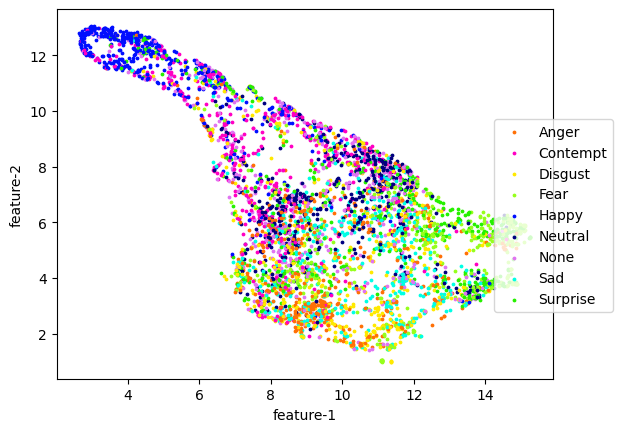

In [45]:
tokens, labels = CLS_tokens(model,
                            feature_extractor,
                            val_label_dataset,
                            device)
plot_tokens(tokens, labels, 10)